## ダーツボードの自動得点計算

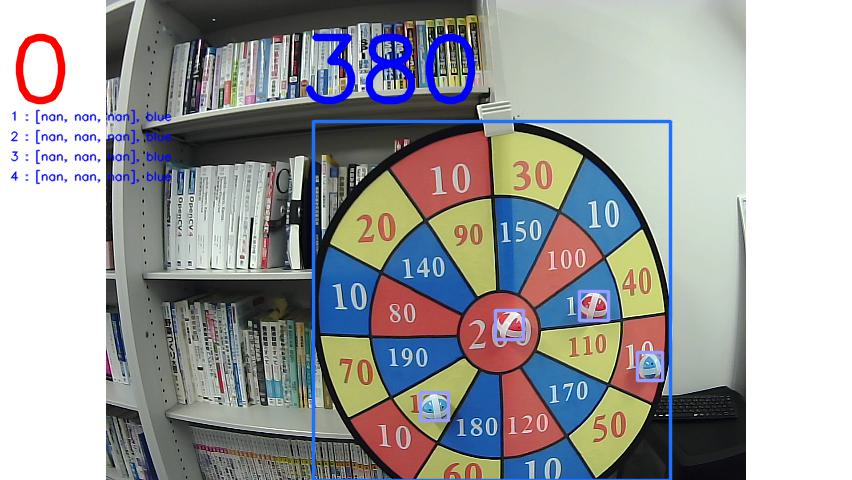

In [1]:
import cv2
import os
import IPython

from io import BytesIO
from PIL import Image

from dartboard_evaluator2 import DartboardEvaluator2


# 画像をjpegバイナリに変換してIpythonで表示する
def show(a, fmt='jpeg'):
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    IPython.display.clear_output(wait=True)

def get_ball_color(img):
    mean_color_rgb = img.mean(axis=(0, 1))
    
    if mean_color_rgb[0] >= mean_color_rgb[2]: # R成分がB成分より大きい場合
        return "red"
    elif mean_color_rgb[2] > mean_color_rgb[0]: # B成分がR成分より大きい場合
        return "blue"

darts_eval = DartboardEvaluator2(yolo_model_path = "./models/20230727-1623_yolov8s_sentan-B_v4/weights/best.pt")

cap = cv2.VideoCapture(0)
assert cap.isOpened(), 'Could not open video device'
try:
    while(True):
        ret, frame = cap.read() 

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (640, 480))

            red_score_list, blue_score_list = darts_eval(frame)
            frame = darts_eval.get_visualized_img()
            
            # frameを左右拡張160pxずつ拡張して16:9（852x480）にする
            frame = cv2.copyMakeBorder(frame, 0, 0, 106, 106, cv2.BORDER_CONSTANT, value=(255, 255, 255))
            
            frame = cv2.putText(frame, str(sum(red_score_list)), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5, cv2.LINE_AA)
            frame = cv2.putText(frame, str(sum(blue_score_list)), (300, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 5, cv2.LINE_AA)
            
            count = 0
            for i, ball in enumerate(darts_eval.get_balls()):
                # bbox_coord = list(map(int, box[0:4]))
                
                # conf = box[4]
                # label = int(box[5])
                
                count += 1
                if ball.color[0] > ball.color[2]: # R成分がB成分より大きい場合
                    text = f"{count} : {ball.color}, red"
                    frame = cv2.putText(frame, text, (10, 120+(20*i)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1, cv2.LINE_AA)
                else: 
                    text = f"{count} : {ball.color}, blue"
                    frame = cv2.putText(frame, text, (10, 120+(20*i)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
                    
            show(frame)

except KeyboardInterrupt:
    cap.release()
    print('Stream stopped')